In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [101]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import json
import folium
from IPython.display import display
import branca.colormap as cm
from folium.features import FeatureGroup
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import IFrame
%matplotlib inline

# Unemployement rates in Europe

**Assumption:** The dataset we use contains unemployment rates for the last 10 years which we consider *"recent dates"*.

The unemployment dataset for **Europe** can be found under `Database by theme > population and social condition > Labour market > Employment and unemployment > LFS series > Total Unemployment > Unemployment by Age, sex and nationality`.

In [63]:
DIR_TOPOJSON = './topojson/'

# Europe's and Switzerland's json files paths
cantons_geo_path = DIR_TOPOJSON+r'ch-cantons.topojson.json'

# Load Europe's and Switzerland's json files
cantons_json_data = json.load(open(cantons_geo_path))
euro_geo_json = json.load(open('europe.geojson'))

In [64]:
DIR_UNEMPLOYMENT = 'lfsa_urgan_1_Data.csv'

# Store unemployment Data in DataFrame
unemployment_data = pd.read_csv(DIR_UNEMPLOYMENT , usecols=['TIME','SEX','GEO','Value'])
unemployment_data = unemployment_data.loc[unemployment_data.SEX == 'Total']
unemployment_data.drop('SEX', axis=1)

# Replace coutry name to fit the topo/geo json country name. 
unemployment_data.GEO[unemployment_data.GEO == 'Germany (until 1990 former territory of the FRG)'] = 'Germany'
unemployment_data.GEO[unemployment_data.GEO == 'Former Yugoslav Republic of Macedonia, the'] = 'The former Yugoslav Republic of Macedonia'

# Compute mean unemployment rate over years for every country
unemployment_data_original = unemployment_data
unemployment_data = unemployment_data.groupby('GEO')['Value'].mean()

# Remove some Data(all Europe ...)
unemployment_data = unemployment_data.drop(unemployment_data.index[[8,9,10,11,12,13]])
display(unemployment_data.sort_values(ascending=False))

display(HTML("<b>Unemployment rates in Spain</b>"))
display(unemployment_data_original.loc[unemployment_data_original.GEO == 'Spain'].drop('SEX', axis=1))

GEO
The former Yugoslav Republic of Macedonia    30.22
Spain                                        19.58
Greece                                       18.34
Croatia                                      13.30
Latvia                                       12.42
Slovakia                                     12.32
Portugal                                     11.94
Lithuania                                    11.00
Ireland                                      10.81
Cyprus                                        9.91
Turkey                                        9.89
Italy                                         9.66
Bulgaria                                      9.44
Estonia                                       9.16
France                                        9.13
Hungary                                       8.82
Poland                                        8.74
Finland                                       8.05
Belgium                                       7.87
Slovenia                   

,TIME,GEO,Value
42,2007,Spain,8.2
159,2008,Spain,11.3
276,2009,Spain,17.9
393,2010,Spain,19.9
510,2011,Spain,21.4
627,2012,Spain,24.8
744,2013,Spain,26.1
861,2014,Spain,24.5
978,2015,Spain,22.1
1095,2016,Spain,19.6


**Interaction**: Our interaction will be based on the fact that some countries have a high unemployment rate during crisis periods, therefore we show the minimum and maximum unemployment rates of each country. This can be illustrated (see above) by the case of ***Spain*** where the unemployment rate reachs a maximum of **26.1%** unemployment at 2016 while having an average of **19.6%** unemployment on 10 years.

**Scale**: We choose to scale the choropleth map based on the quantile values. Besides, we add an extra range to clearly show the outliers.

In [107]:
def get_info_toshow(df, name):
    ''' Helper function that returns the html text to 
        show in the popup.'''
    html = """
            <b>{} unemployment rate</b><br>
            <ul>
                <li><b>Avg<b>: {:.3}</li>
                <li><b>Max<b>: {:.3} ({})</li>
                <li><b>Min<b>: {:.3} ({})</li>
            </ul>
           """
    df = df.loc[df.GEO == name]
    avg_ = df['Value'].mean()
    max_, maxyear = df['Value'].max(), df.loc[df.Value == df['Value'].max()]['TIME'].min()
    min_, minyear = df['Value'].min(), df.loc[df.Value == df['Value'].min()]['TIME'].min()
    return html.format(name, avg_, max_, maxyear, min_, minyear)
    
# Europe's coordinates
europe_coord = [53,9]
# Map centerd in Europe
m_europe = folium.Map(europe_coord, zoom_start=4, tiles='cartodbpositron')

# Define colormap scale
scale = unemployment_data.quantile([0,.25, .5, .75, 0.94, 1]).values
colormap= cm.StepColormap(['#ffffb2','#fed976','#feb24c','#fd8d3c','#f03b20', 'red'], vmin=scale[0], vmax=scale[-1],index=scale,caption='step')

# Plot each country separatly to enable popup
for feature in euro_geo_json['features']:
    name = feature['properties']['NAME']
    rate = unemployment_data.get(name,'')
    if(rate != ''):
        feature['properties']['fill'] = colormap(rate)
        gj = folium.GeoJson(
            data=feature,style_function= lambda feature_:  {
            'fillColor' : feature_['properties']['fill'],
            'color': 'black',
            'weight': 1,
            'dashArray': '0, 0',
            'fillOpacity': 0.9,
            }
        )
        html = get_info_toshow(unemployment_data_original, name)
        gj.add_child(folium.Popup(html))
        gj.add_to(m_europe)


colormap.caption = 'Unemployment rates by country'
colormap.add_to(m_europe)
display(HTML("<center><h4>Click on a country to interact with the map.</h4></center>"))

# Saving the Europe map
m_europe.save('europe_unemployment.html')

#Loading the map
IFrame('europe_unemployment.html', width=1000, height=600)

From the map above, we can see that the **Nothern part** of Europe have low unemployment rates compared to the **Southern part** and the **Eastern part**.<br>
- The top 3 countries with the **highest** rates are: Macedonia,Spain and Greece.<br>
- The top 3 countries with the **lowest** rates are: Norway,Switzerland and Iceland.

## Unemployment in Switzerland

In [118]:
                                    ''' Helper functions for Switzerland '''

def date_2_year(x):
    ''' Convert a date to year '''
    splitted = x.split(" ")
    if len(splitted) <= 1:
        return np.nan
    return splitted[1]

def show_map_swiss(legend, data, columns, scale, color='OrRd', add_code=True, map_=None):
    '''Show Switzerland map without layering'''
    global cantons_json_data
    # Add the canton code associated to every entry in the data frame 
    # the correspendence between canton's name and codes is done manually and saved in a csv file
    if add_code:
        canton_codes = pd.read_csv('cantons_code.csv', dtype='str')
        data = pd.merge(data, canton_codes, on='Canton')
    swiss_coord = [46.8182, 8.2275]
    if map_ is None:
        map_ = folium.Map(swiss_coord, zoom_start=8, tiles='cartodbpositron')
    map_.choropleth(geo_data=cantons_json_data,
                        data=data,
                        columns=columns,
                        fill_color=color, 
                        fill_opacity=1.0,
                        key_on='feature.id',
                        topojson='objects.cantons',
                        line_opacity=0.2,
                        legend_name=legend,
                        threshold_scale=scale)
    return map_

def concatenate(data,col):
    ''' Add the canton code associated to every entry in the data frame and set canton's code as a index
    for the returned serie <col> '''
    canton_codes = pd.read_csv('cantons_code.csv', dtype='str')
    data = pd.merge(data, canton_codes, on='Canton').set_index('Code')[col]
    return data


        
def show_layered_swiss(dict_,colormap,map_=None,layer_name=None):
    '''Adds  a new layer to the map passed in parameters with name 'layer_name' or create a new map with a new layer if map_ = None . The final map contains layers that can be selected through
    a radio button'''
    global cantons_json_data
    swiss_coord = [46.8182, 8.2275]

    def style_function(feature):
        ''' Map styling function, Colorate the canton as specified by the colormap and set their borders properties'''
        return  {
        'fillColor': colormap(dict_[feature['id']]),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.9,
        }
    # Create new map it is not already passed in parameter  
    if(map_ is None):
        map_ = folium.Map(swiss_coord, zoom_start=8, tiles='cartodbpositron')
        
    # Add the new layer with the specified data passed in dict_ and the corresponding layer_name
    # Topojson is used instead of the choropleth function since the latter doesn't allow customizeable layers 
    feature_group = FeatureGroup(name=layer_name,overlay=False)
    folium.TileLayer(tiles='cartodbpositron',control=False).add_to(feature_group)
    folium.TopoJson(cantons_json_data,'objects.cantons',style_function=style_function,name=layer_name).add_to(feature_group)
    feature_group.add_to(map_)
    return map_

### Unemployement rate including employed and looking for a job

In [108]:
df = pd.read_excel('swiss_unemp.xlsx', header=[0,1])

# Clean data and extract unemp rate only
swiss_unem_rate = df.loc[:, df.columns.get_level_values(1) == 'Taux de chômage']
swiss_unem_rate.columns = swiss_unem_rate.columns.droplevel(level=1)
swiss_unem_rate = swiss_unem_rate.transpose().drop('Total')

# Extract year from the date and group the values by year
swiss_unem_rate['Year'] = pd.Series(swiss_unem_rate.index).apply(date_2_year).tolist()
swiss_unem_rate = pd.DataFrame(swiss_unem_rate.groupby('Year').mean().mean(axis=0)).reset_index()
swiss_unem_rate.columns = ['Canton', 'Rate']

# Show map
scale_unemp_swiss = list(swiss_unem_rate['Rate'].quantile([0,.25, .5, .75, 1]))
swiss_unemp_map = show_map_swiss('Unemployment rates in Switzerland by cantons', 
               swiss_unem_rate,
               ['Code', 'Rate'], 
               scale_unemp_swiss)

# Saving the map
swiss_unemp_map.save('swiss_unemployment.html')

#Loading the map
IFrame('swiss_unemployment.html', width=1000, height=600)

**Note**: *Here we include the people looking for job in our unemployment rates.*

We can clearly see that the **western** and **southern sides** of Switzerland suffer from higher rates of unemployment compared to the **eastern side**.

The top 3 cantons with the **highest** unemployment rates are:Geneva,Neuchatel and Vaud.<br>
The top 3 cantons with the **lowest** unemployment rates are:Obwald,Appenzel Rhodes-Intérieures and Uri.

### Unemployement rate excluding employed people looking for a job

**Scale**: For comparison purposes, we used the same scale for both maps.

In [111]:
''' Compute the unemployment rate exluding (T) the people looking for a job as follows:
    T = (Chomeurs inscrits*Taux de chomage)/(Chomeurs inscrits+Demandeurs d'emploi non-chomeur)
'''
swiss_unemployed_rate = df.drop(['Mois','Total'], level=0, axis=1).stack().groupby(level=(0,)).agg(lambda x: (x[0]*x[2])/(x[0]+x[1])).transpose()
swiss_unemployed_rate['Year'] = pd.Series(swiss_unemployed_rate.index).apply(date_2_year).tolist()
swiss_unemployed_rate = pd.DataFrame(swiss_unemployed_rate.groupby('Year').mean().mean(axis=0)).reset_index()
swiss_unemployed_rate.columns = ['Canton', 'Rate']

# display(pd.merge(swiss_unemployed_rate.set_index('Canton'),swiss_unem_rate.set_index('Canton')))
# #                  .join(swiss_unem_rate, on='Canton', lsuffix='_with_employed', rsuffix='_without_employed'))

# Show map
swiss_map_without_employed = show_map_swiss('Unemployment rates (excluding working people) in Switzerland by cantons', 
               swiss_unemployed_rate,
               ['Code', 'Rate'], 
               scale_unemp_swiss)

# Saving the map
swiss_map_without_employed.save('swiss_unemployment_without_employed.html')

#Loading the map
IFrame('swiss_unemployment_without_employed.html', width=1000, height=600)

**Note**: *Here we exclude the people looking for job in our unemployment rates.*

The distribution of rates here is similar to the ones in map above.

**Interpretation**: After removing the employed people looking for a job, we notice that the rates drop considerably within cantons, except from some french speaking regions.

### Foreigner vs Swiss unemployment in Switzerland

In [113]:
# Import the csv file containing the unemployement rate rates in Switzerland and preprocess it to keep only need columns
df_nationalities = pd.read_csv('2_1 Taux de chômage.csv', header=[0,1], encoding='utf-16',na_values = '...').drop(['Mois', 'Total'], axis=1, level=0)
df_nationalities.columns = df_nationalities.columns.droplevel(level=1)
df_nationalities = df_nationalities.set_index(['Canton','Nationalité'])
df_nationalities= df_nationalities.apply(pd.to_numeric)
df_nationalities = df_nationalities.drop('Total', axis=0, level=0).reset_index()
# Add a new column containing the mean unemployment rate over the selected period
df_nationalities['Rate'] = df_nationalities.loc[:, 'Décembre 2006':'Septembre 2017'].mean(axis=1)
df_nationalities = df_nationalities[['Canton', 'Nationalité', 'Rate']]

# Swiss and foreigners unemployment rate by canton
df_foreigners = df_nationalities.loc[df_nationalities['Nationalité'] == 'Etrangers', ['Canton','Rate']]
df_swiss = df_nationalities.loc[df_nationalities['Nationalité'] == 'Suisses', ['Canton','Rate']]

scale = (pd.concat([(df_foreigners.quantile([0,0.25,0.5,0.75,1])),df_swiss.quantile([0,0.25,0.5,0.75,1])]).sort_values(by='Rate').reset_index()).loc[[0,2,4,6,8,9]].Rate.tolist()

# Add the canton code
df_swiss = concatenate(df_swiss,'Rate')
df_foreigners = concatenate(df_foreigners,'Rate')

# Display map with two layers
colormap= cm.StepColormap(['#ffffb2','#fed976','#feb24c','#fd8d3c','#f03b20','#bd0026'], vmin=scale[0], vmax=scale[-1], index=scale, caption='step')
CH_map = show_layered_swiss(df_swiss,colormap,layer_name=' swiss people unemployement rate')
colormap.caption = 'Unemployment rates in Switzerland by cantons'
colormap.add_to(CH_map)
show_layered_swiss(df_foreigners ,colormap,layer_name=' Foreign people unemployement rate',map_=CH_map)
folium.LayerControl().add_to(CH_map)
display(HTML('<center><h4>Select layers using the menu on the top right side.</h4></center>'))

# Saving the map
CH_map.save('swiss_unemployment_foreigner.html')

# Loading the map
IFrame('swiss_unemployment_foreigner.html', width=1000, height=600)

For **both swiss and foreigners** we observe that the unemployment rate gets **higher** as we move to the **western, most southern and most northern parts** of Switerzland. However, for foreigners the rates are higher independently of the region.
As it will be seen from below, this distribution is correlated to the language spoken in the region.

### Unemployment rate per age

In [114]:
# Import the csv file containing the unemployement rate rates in Switzerland and preprocess it to keep only need columns
df_ages = pd.read_csv('unemployement_CH_per_age.csv', header=[0,1], encoding='utf-16',na_values = '...').drop(['Mois', 'Total'], axis=1, level=0)
df_ages.columns = df_ages.columns.droplevel(level=1)
df_ages =  df_ages.loc[:, ~df_ages.columns.str.contains('^Unnamed')]
df_ages= df_ages.rename(columns = {"Classes d'âge 15-24, 25-49, 50 ans et plus":'Age class'})
df_ages['Age class'] = df_ages['Age class'].apply(lambda x : '15-24 Years old' if(x == 1) else '25-49 Years old' if (x==2) else '50 Years old or more')
df_ages = df_ages.set_index(['Canton','Age class']) 
df_ages= df_ages.apply(pd.to_numeric)
df_ages = df_ages.drop('Total', axis=0, level=0).reset_index()

# Add a new column containing the mean unemployment rate over the selected period
df_ages['Rate'] = df_ages.loc[:, 'Décembre 2006':'Septembre 2017'].mean(axis=1)
df_ages = df_ages[['Canton', 'Age class', 'Rate']]
df_ages.head()

,Canton,Age class,Rate
0,Zurich,15-24 Years old,3.690000
1,Zurich,25-49 Years old,3.311538
2,Zurich,50 Years old or more,2.678462
3,Berne,15-24 Years old,2.733846
4,Berne,25-49 Years old,2.396154


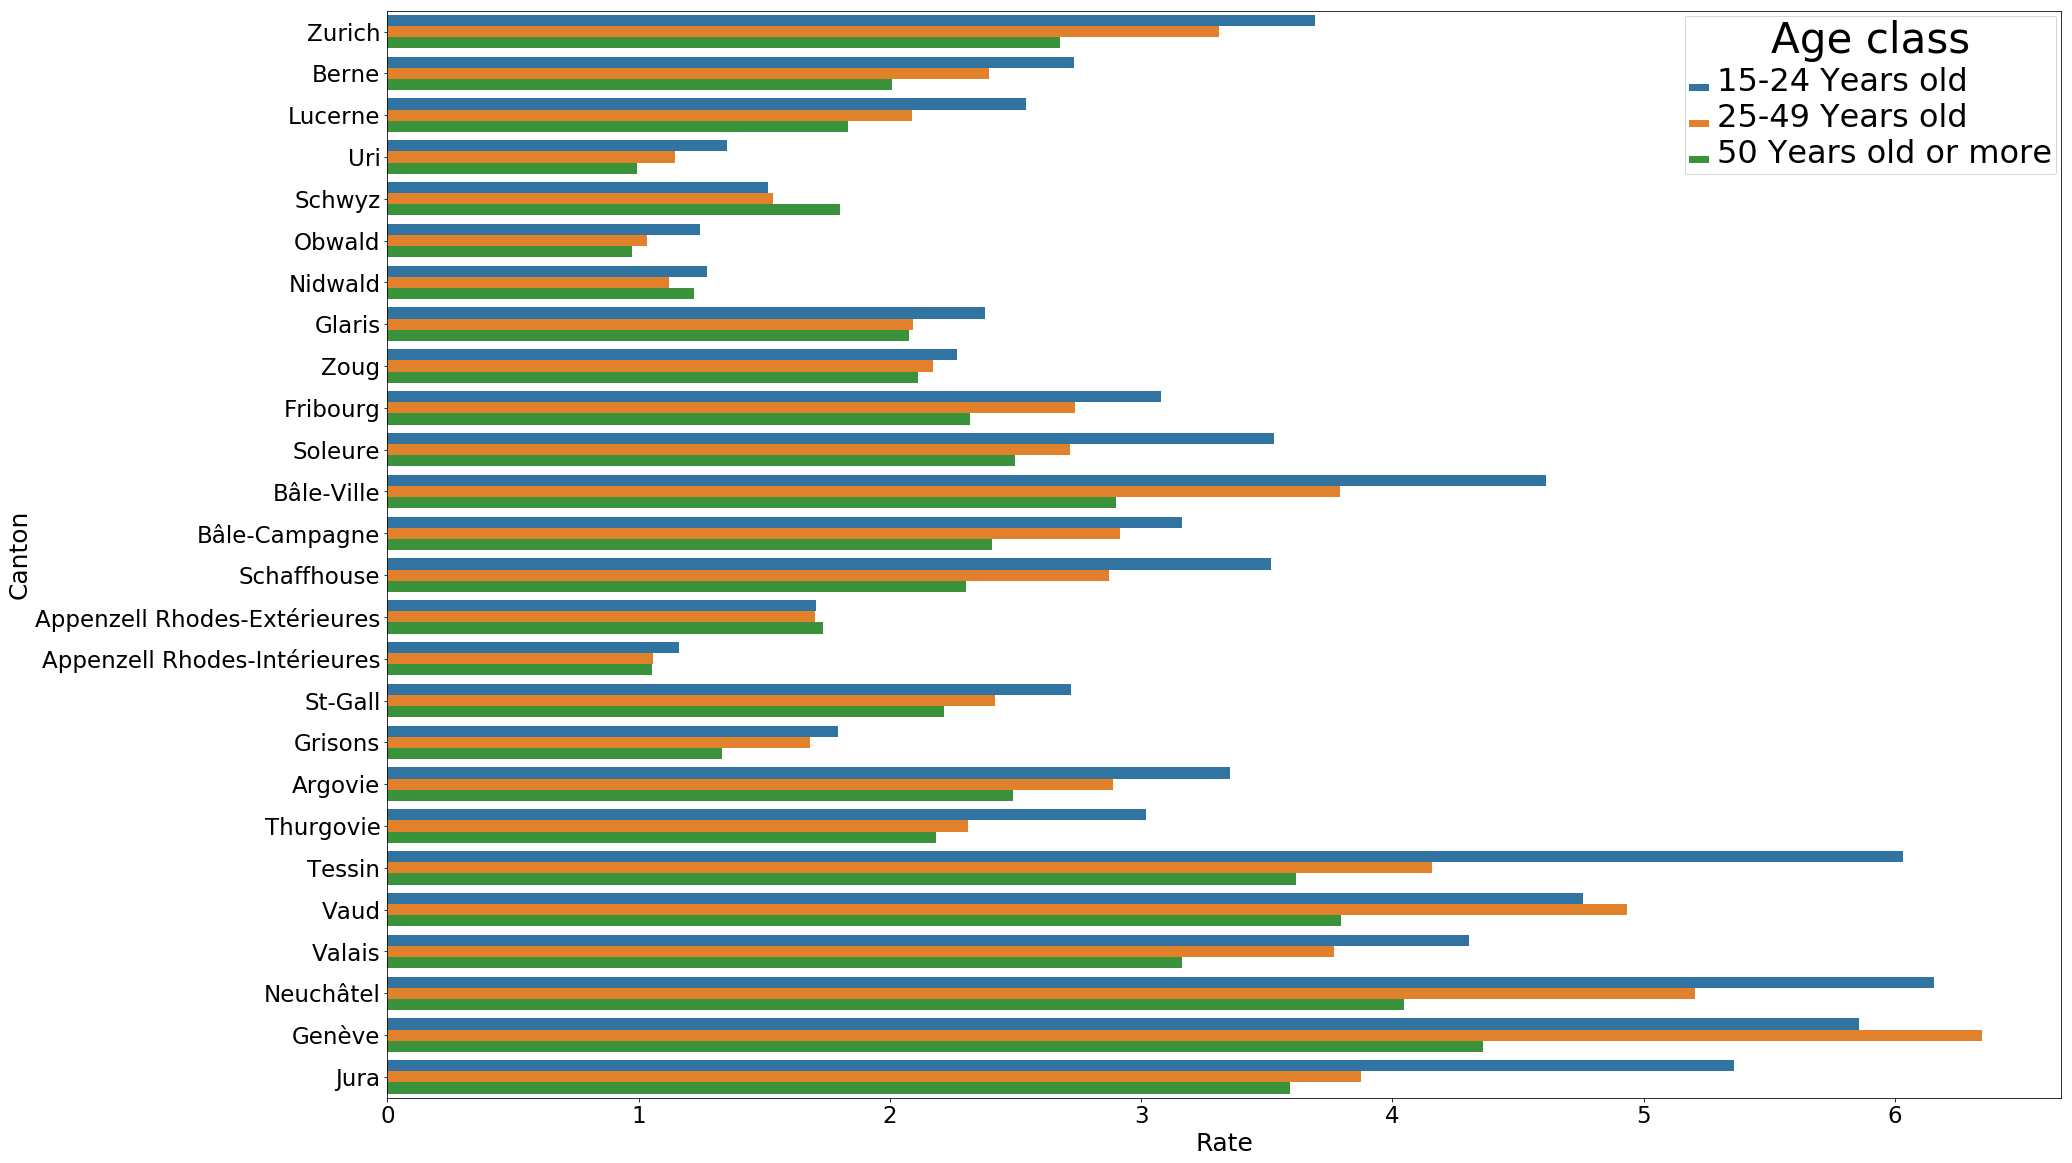

In [115]:
# Plot the unemployment rate by age class and by canton in Switzerland as a bar chart
fig, ax = plt.subplots(figsize = (30,20))
g = sns.factorplot(ax = ax,y="Canton", x="Rate",
                   hue="Age class",
                   data=df_ages, kind="bar");
plt.setp(ax.get_xticklabels(), fontsize=23)
plt.setp(ax.get_yticklabels(), fontsize=23)
g.fig.subplots_adjust(hspace=3, wspace=1)
plt.setp(ax.get_legend().get_texts(), fontsize=32) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=42) # for legend title

ax.xaxis.label.set_size(25)
ax.yaxis.label.set_size(25)
plt.close(g.fig)

From the barcharts above,we make the following observations:

  - For almost all cantons, unemployment rate for **the young population(15-24 years old)** is **higher** than the rest of population.This can be explained by the high number of students within this age range.<br>
  - **French/Italian speaking cantons** have the **highest** unemployment rates compared to the German ones.This can be explaied by the concentration of most industries and economic activities in the German part of Switzerland (this point will be further confirmed below).

## Bonus

**Assumptions**: 
- We don't include 'Romanch' in our map.
- We take only the most spoken language in cantons speaking more than one language.

In [119]:
# Mapping cantons to spoken language
french_cantons = ['Vaud','Neuchâtel','Genève','Fribourg','Valais','Jura']
german_cantons = ['Zurich','Berne','Lucerne','Uri','Schwyz','Obwald','Nidwald','Glaris','Zoug','Soleure','Bâle-Ville','Bâle-Campagne','Schaffhouse','Appenzell Rhodes-Extérieures','Appenzell Rhodes-Intérieures','St-Gall','Argovie','Thurgovie','Grisons']
italian_cantons = ['Tessin']

french_mask = swiss_unem_rate.Canton.isin(french_cantons)
german_mask = swiss_unem_rate.Canton.isin(german_cantons)
italian_mask = swiss_unem_rate.Canton.isin(italian_cantons)

# Assigning the average unemployment rate per spoken language to cantons
swiss_unem_rate.loc[french_mask, 'Rate'] = swiss_unem_rate.loc[french_mask, 'Rate'].mean()
swiss_unem_rate.loc[german_mask, 'Rate'] = swiss_unem_rate.loc[german_mask, 'Rate'].mean()
swiss_unem_rate.loc[italian_mask, 'Rate'] = swiss_unem_rate.loc[italian_mask, 'Rate'].mean()

# Plot the map 
swiss_coord = [46.8182, 8.2275]
map_ = folium.Map(swiss_coord, zoom_start=8, tiles='cartodbpositron', min_zoom=8, max_zoom=10)
map_ = show_map_swiss('Unemployment rates in Switzerland by spoken language', 
                        swiss_unem_rate,
                        ['Code', 'Rate'], 
                        scale=[2.2,3,4.26,4.5],
                        map_=map_)

# Adding labels to each region
french_coord = [46.7, 6.6]
german_coord = [47.20, 8.2275]
italian_coord = [46.47, 8.63]
folium.map.Marker(german_coord,icon=folium.DivIcon(html='<h2>German<h2>')).add_to(map_)
folium.map.Marker(french_coord,icon=folium.DivIcon(html='<h3>French<h3>')).add_to(map_)
folium.map.Marker(italian_coord,icon=folium.DivIcon(html='<h3>Italian<h3>')).add_to(map_)

# Saving the map
map_.save('swiss_unemployment_language.html')

# Loading the map
IFrame('swiss_unemployment_language.html', width=1000, height=600)

We can see that the **german** speaking part has a **low** unemployment rate **compared to** the **french** and **italian** part which have almost similar rates.